## Verbosity analysis of projects submitted to the our repository

One of the principles we highlight to our learners when building data pipelines is *communication*. It refers to the ability to communicate properly to the stakeholders in a clear and concise manner. For instance, they should be able to outline their assumptions and decisions for a given task, and discuss their findings after solving the task. In this regard, we often reject solutions notebooks that only contain code, without any explanation.

To address this issue, I suggest implementing a **Github Action** that checks if the notebook contains markdown cells with sufficient content. Upon their submissions, learners with poorly documented notebooks will receive a warning message, prompting them to add more content to their notebooks. 
Following is an interim analysis of the verbosity of the existing notebooks in extension school repos. The workflow is implemented in a seperate private repository.

In [1]:
import os
import re
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from github import Github
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

%load_ext lab_black

### GitHub Authenticaton

In [2]:
# Retrieve the GitHub token from environment variable
token = os.getenv("GITHUB_TOKEN")

# authenticate to github
g = Github(token)

# get the authenticated user
user = g.get_user()

### Setup the path

In [3]:
path = r"/Users/khalilza/Github_clones/GHAction_repo/"
local_repo_name_p1 = "project-1-notebooks"
local_repo_name_p2 = "project-2-notebooks"
local_repo_name_p3 = "project-3-notebooks"
local_repo_name_p4 = "project-4-notebooks"


if not os.path.exists(local_repo_name_p1):
    os.mkdir(local_repo_name_p1)
if not os.path.exists(local_repo_name_p2):
    os.mkdir(local_repo_name_p2)
if not os.path.exists(local_repo_name_p3):
    os.mkdir(local_repo_name_p3)
if not os.path.exists(local_repo_name_p4):
    os.mkdir(local_repo_name_p4)

### Store the notebooks using Github API

In total we have about 1400 [repositories](https://github.com/epfl-extension-school) that should be analyzed. Our ML program has four modules and one project per module. For each projects, and for every user, the following steps are performed:

1. iterate over the contents of their repository using get_contents() method
2. if the content is a directory, iterate over its subcontents, and check if the subcontent is a notebook
3. handle base64 and non-base64 encoded content, and write the decoded_content to a file
4. do the same if the content is a notebook, again handle base64 and non-base64 encoded content, update the file



In [ ]:
# get the repo names and get the notebooks from the remote repo
# don't forget to clear the cell output for privacy reasons

# run the helper functions
%run utils.py

remote_repo_name = ['project-adsml19-c1-s10','project-adsml-ibex-c1-s11'] # 84+53  
cnt1 = get_notebooks(user, remote_repo_name, local_repo_name_p1)

remote_repo_name = ['project-adsml-ibex-c2-s10','project-adsml19-c2-s9'] # 50+96  
cnt2 = get_notebooks(user, remote_repo_name, local_repo_name_p2)

remote_repo_name = ['project-adsml-ibex-c3-s9','project-adsml19-c3-s9'] # 30+84  
cnt3 = get_notebooks(user, remote_repo_name, local_repo_name_p3)

remote_repo_name = ['project-adsml-ibex-c4-s11','project-adsml19-c4-s11'] # 25+84  
cnt4 = get_notebooks(user, remote_repo_name, local_repo_name_p4)

# how many notebooks are downloaded
cnt1, cnt2, cnt3, cnt4, np.sum([cnt1, cnt2, cnt3, cnt4])

### Get the word counts in the Markdown cells

It's time to count the words in the markdown cells. To do that I:
1. iterate over sorted list of notebooks
2. check if notebook name does not contain any stop words, to exclude the notebooks that are not related to main projects or are revised versions of the same project, or are checkpoints, etc
3. load notebook using nbformat.reads()
4. collect markdown cells
5. calculate word count for the notebook and append to list

In [4]:
p1_notebooks = glob.glob(path + local_repo_name_p1 + "/*.ipynb")
p2_notebooks = glob.glob(path + local_repo_name_p2 + "/*.ipynb")
p3_notebooks = glob.glob(path + local_repo_name_p3 + "/*.ipynb")
p4_notebooks = glob.glob(path + local_repo_name_p4 + "/*.ipynb")


print(len(p1_notebooks + p2_notebooks + p3_notebooks + p4_notebooks))

2067


in total there are 2067 notebooks in the repositories

In [5]:
%run utils.py

word_count, cnt = count_words(p1_notebooks + p2_notebooks + p3_notebooks + p4_notebooks)

df = pd.DataFrame(word_count)
df.columns = ["path", "word counts"]
df

,path,word counts
0,/Users/khalilza/Github_clones/GHAction_repo/pr...,1201.0
1,/Users/khalilza/Github_clones/GHAction_repo/pr...,0.0
2,/Users/khalilza/Github_clones/GHAction_repo/pr...,820.0
3,/Users/khalilza/Github_clones/GHAction_repo/pr...,559.0
4,/Users/khalilza/Github_clones/GHAction_repo/pr...,35.0
...,...,...
1774,/Users/khalilza/Github_clones/GHAction_repo/pr...,608.0
1775,/Users/khalilza/Github_clones/GHAction_repo/pr...,352.0
1776,/Users/khalilza/Github_clones/GHAction_repo/pr...,227.0
1777,/Users/khalilza/Github_clones/GHAction_repo/pr...,277.0


### Some quick cleaning and checking

In [6]:
# cut the unnecesary text
df["path"] = df["path"].str.replace(
    "/Users/khalilza/Github_clones/GHA_repo/project-1-notebooks/epfl-extension-school-project-",
    "",
)
df["path"] = df["path"].str.replace(
    "/Users/khalilza/Github_clones/GHA_repo/project-2-notebooks/epfl-extension-school-project-",
    "",
)
df["path"] = df["path"].str.replace(
    "/Users/khalilza/Github_clones/GHA_repo/project-3-notebooks/epfl-extension-school-project-",
    "",
)
df["path"] = df["path"].str.replace(
    "/Users/khalilza/Github_clones/GHA_repo/project-4-notebooks/epfl-extension-school-project-",
    "",
)

# cut the subject name
df["path"] = df["path"].str.replace("-s11|-s10|-s9", "")

# get the course name
df["project"] = df["path"].str.extract("(c[1234])", expand=True)

d = {"c1": "project 1", "c2": "project 2", "c3": "project 3", "c4": "project 4"}
for k, v in d.items():
    df["project"] = df["project"].str.replace(k, v)

# get the program version
df["version"] = df["path"].str.extract("(adsml19+)", expand=True)
df["version"].fillna("adsml-ibex", inplace=True)
df

,path,word counts,project,version
0,/Users/khalilza/Github_clones/GHAction_repo/pr...,1201.0,project 1,adsml-ibex
1,/Users/khalilza/Github_clones/GHAction_repo/pr...,0.0,project 1,adsml-ibex
2,/Users/khalilza/Github_clones/GHAction_repo/pr...,820.0,project 1,adsml-ibex
3,/Users/khalilza/Github_clones/GHAction_repo/pr...,559.0,project 1,adsml-ibex
4,/Users/khalilza/Github_clones/GHAction_repo/pr...,35.0,project 1,adsml-ibex
...,...,...,...,...
1774,/Users/khalilza/Github_clones/GHAction_repo/pr...,608.0,project 4,adsml19
1775,/Users/khalilza/Github_clones/GHAction_repo/pr...,352.0,project 4,adsml19
1776,/Users/khalilza/Github_clones/GHAction_repo/pr...,227.0,project 4,adsml19
1777,/Users/khalilza/Github_clones/GHAction_repo/pr...,277.0,project 4,adsml19


In [7]:
# the new version of the program has less repositories
df.version.value_counts()

adsml19       1262
adsml-ibex     517
Name: version, dtype: int64

In [8]:
# breakdown by project
df.project.value_counts()

project 4    1000
project 2     314
project 3     291
project 1     174
Name: project, dtype: int64

In [9]:
#  how many per project and program version
pd.crosstab(df.version, df.project)

project,project 1,project 2,project 3,project 4
version,,,,
adsml-ibex,106,108,69,234
adsml19,68,206,222,766


In [10]:
# get the unique repo codes
df["repo"] = df["path"].apply(lambda x: re.findall("(-)(\d{4})|(-)(\d{3})", x))
df

,path,word counts,project,version,repo
0,/Users/khalilza/Github_clones/GHAction_repo/pr...,1201.0,project 1,adsml-ibex,"[(-, 2199, , ), (-, 3557, , )]"
1,/Users/khalilza/Github_clones/GHAction_repo/pr...,0.0,project 1,adsml-ibex,"[(-, 2825, , ), (-, 3751, , )]"
2,/Users/khalilza/Github_clones/GHAction_repo/pr...,820.0,project 1,adsml-ibex,"[(-, 2825, , ), (-, 3751, , )]"
3,/Users/khalilza/Github_clones/GHAction_repo/pr...,559.0,project 1,adsml-ibex,"[(-, 3325, , ), (-, 3084, , )]"
4,/Users/khalilza/Github_clones/GHAction_repo/pr...,35.0,project 1,adsml-ibex,"[(-, 3356, , ), (-, 3263, , )]"
...,...,...,...,...,...
1774,/Users/khalilza/Github_clones/GHAction_repo/pr...,608.0,project 4,adsml19,"[(-, 5447, , ), (-, 3033, , )]"
1775,/Users/khalilza/Github_clones/GHAction_repo/pr...,352.0,project 4,adsml19,"[(-, 5447, , ), (-, 3033, , )]"
1776,/Users/khalilza/Github_clones/GHAction_repo/pr...,227.0,project 4,adsml19,"[(-, 5447, , ), (-, 3033, , )]"
1777,/Users/khalilza/Github_clones/GHAction_repo/pr...,277.0,project 4,adsml19,"[(-, 5447, , ), (-, 3033, , )]"


In [11]:
# Remove special characters from the 'repo' column
df["repo"] = df["repo"].apply(lambda x: re.sub(r"[-,.()\[\]\']", "", str(x)))

# Remove leading whitespace from the 'repo' column
df["repo"] = df["repo"].str.lstrip()

# Remove trailing whitespace from the 'repo' column
df["repo"] = df["repo"].str.rstrip()

# Display the DataFrame
df

,path,word counts,project,version,repo
0,/Users/khalilza/Github_clones/GHAction_repo/pr...,1201.0,project 1,adsml-ibex,2199 3557
1,/Users/khalilza/Github_clones/GHAction_repo/pr...,0.0,project 1,adsml-ibex,2825 3751
2,/Users/khalilza/Github_clones/GHAction_repo/pr...,820.0,project 1,adsml-ibex,2825 3751
3,/Users/khalilza/Github_clones/GHAction_repo/pr...,559.0,project 1,adsml-ibex,3325 3084
4,/Users/khalilza/Github_clones/GHAction_repo/pr...,35.0,project 1,adsml-ibex,3356 3263
...,...,...,...,...,...
1774,/Users/khalilza/Github_clones/GHAction_repo/pr...,608.0,project 4,adsml19,5447 3033
1775,/Users/khalilza/Github_clones/GHAction_repo/pr...,352.0,project 4,adsml19,5447 3033
1776,/Users/khalilza/Github_clones/GHAction_repo/pr...,227.0,project 4,adsml19,5447 3033
1777,/Users/khalilza/Github_clones/GHAction_repo/pr...,277.0,project 4,adsml19,5447 3033


### Sum up the word counts by project and plot the results

In [12]:
# group by learner, program version and project
df1 = (
    df.drop("path", axis=1).groupby(["repo", "version", "project"]).sum().reset_index()
)
df1.head()

,repo,version,project,word counts
0,1233 882,adsml19,project 4,1498.0
1,1362 2922,adsml19,project 2,2910.0
2,1384 1531,adsml19,project 4,1839.0
3,1469 649,adsml19,project 4,897.0
4,1476 656,adsml19,project 1,2248.0


In [13]:
# check a random learner
df.loc[df.repo.str.contains("3639")]

,path,word counts,project,version,repo
281,/Users/khalilza/Github_clones/GHAction_repo/pr...,3509.0,project 2,adsml-ibex,6482 3639
555,/Users/khalilza/Github_clones/GHAction_repo/pr...,2078.0,project 3,adsml-ibex,6482 3639
556,/Users/khalilza/Github_clones/GHAction_repo/pr...,323.0,project 3,adsml-ibex,6482 3639
1007,/Users/khalilza/Github_clones/GHAction_repo/pr...,680.0,project 4,adsml-ibex,6482 3639
1008,/Users/khalilza/Github_clones/GHAction_repo/pr...,623.0,project 4,adsml-ibex,6482 3639
1009,/Users/khalilza/Github_clones/GHAction_repo/pr...,724.0,project 4,adsml-ibex,6482 3639
1010,/Users/khalilza/Github_clones/GHAction_repo/pr...,696.0,project 4,adsml-ibex,6482 3639
1011,/Users/khalilza/Github_clones/GHAction_repo/pr...,438.0,project 4,adsml-ibex,6482 3639
1012,/Users/khalilza/Github_clones/GHAction_repo/pr...,80.0,project 4,adsml-ibex,6482 3639


In [15]:
# print the path for the learner for last 3 projects
df.loc[df.repo.str.contains("3639")].path.values[-3:]

array(['/Users/khalilza/Github_clones/GHAction_repo/project-4-notebooks/epfl-extension-school-project-adsml-ibex-c4-6482-3639-04 Logistic regression.ipynb',
       '/Users/khalilza/Github_clones/GHAction_repo/project-4-notebooks/epfl-extension-school-project-adsml-ibex-c4-6482-3639-05 Decision trees and random forest.ipynb',
       '/Users/khalilza/Github_clones/GHAction_repo/project-4-notebooks/epfl-extension-school-project-adsml-ibex-c4-6482-3639-07 Dense network.ipynb'],
      dtype=object)

In [16]:
df1.shape, df1.repo.nunique()

((489, 4), 323)

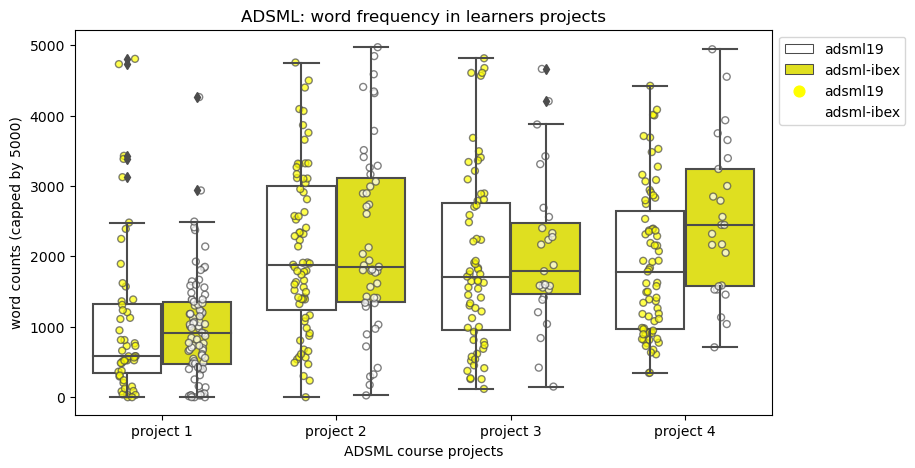

In [20]:
fig, ax = plt.subplots(figsize=(9, 5))

sns.boxplot(
    x="project",
    y="word counts",
    hue="version",
    data=df1[df1["word counts"] < 5000].sort_values("project"),
    palette=["white", "yellow"],
    ax=ax,
)

sns.stripplot(
    x="project",
    y="word counts",
    data=df1[df1["word counts"] < 5000].sort_values("project"),
    hue="version",
    palette=["yellow", "white"],
    dodge=True,
    linewidth=1,  # need edge color to see the dots
    zorder=1,  # keep the median visible
    alpha=0.7,
    ax=ax,
)

plt.title("ADSML: word frequency in learners projects")
plt.xlabel("ADSML course projects")
plt.ylabel("word counts (capped by 5000)")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

As expected there are less cases in the new version, so comparing the word counts in the new version with the old version is not very informative. However, in two projects the median word count in the new version is higher than in the old version, pointing to the fact that the new version of the program insists on more discussion in the notebooks.

In [21]:
df1.groupby(["project"]).describe().round(0)

word counts                                                        
                count    mean     std    min     25%     50%     75%      max
project                                                                      
project 1       136.0  1073.0  1186.0    0.0   426.0   792.0  1358.0   9881.0
project 2       138.0  2977.0  2506.0    0.0  1399.0  2259.0  3619.0  13273.0
project 3       109.0  3102.0  3736.0  118.0  1334.0  1936.0  3683.0  30080.0
project 4       106.0  2537.0  1895.0  344.0  1183.0  2160.0  3140.0  11134.0